## Install Packages

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
from matplotlib import pyplot as plt
from natsort import natsorted
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score
import src
from tqdm.notebook import tqdm
from src.utils.celeba_helper_v2 import CelebADataset, CelebAClassifier, CelebADatasetTriplet #save_file_names
from src.utils.loss_functions import TripletLoss
import shutil
# from torchsummary import summary

workers = 0 if os.name == 'nt' else 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

nGPU = torch.cuda.device_count()
print(device)

cuda:0


## Creating the necessary folders

In [3]:
if not os.path.exists("models"):
    os.makedirs("models")
    
if not os.path.exists("loss_curves"):
    os.makedirs("loss_curves")
    
if not os.path.exists("pytorch_objects"):
    os.makedirs("pytorch_objects")

## Filtering the label file after MTCNN face extraction (enable if you don't have the updated file)

In [4]:
# orig_mapping_file = 'data/identity_CelebA_train_test_split.txt'
# img_folder = 'data/img_align_celeba_mtcnn'

# label_df = pd.read_csv(orig_mapping_file, header=None, sep=" ", names=["file_name", "person_id", "is_train"])

# count=0
# files = []
# for filename in os.listdir(img_folder):
#     files.append(filename)

# file_names = label_df[label_df["file_name"].isin(files)]
# file_names.to_csv("data/identity_CelebA_train_test_split_mtcnn.txt", sep=" ", index=False, header=False)

# Define CelebA Dataset and Loader

In [5]:
class CelebADatasetTriplet(CelebADataset):
    def __init__(self, root_dir, mapping_file: str, transform=None, 
                train: bool = True, img_ext: str = 'jpg'):
        """
        Args:
          root_dir (string): Directory with all the images
          mapping_file (string): File path to mapping file from image to person
          transform (callable, optional): transform to be applied to each image sample
        """
        # Read names of images in the root directory
        image_names = os.listdir(root_dir)
        image_names = [x for x in image_names if x.split(".")[-1]==img_ext]
        print(f'Image names size is: {len(image_names)}')
        self.return_triplets = True
        self.mode = 'train'

        self.file_label_mapping = pd.read_csv(
            mapping_file, header=None, sep=" ", names=["file_name", "person_id", "is_train"]
        )
        self.file_label_mapping = self.file_label_mapping.sort_values(by=["file_name"]).reset_index(drop=True)

        all_images_idx = self.file_label_mapping.index.values

        self.train_df = self.file_label_mapping[self.file_label_mapping["is_train"]==1]
        train_images_idx = self.train_df.index.values
        
        # Define the images that are available for triplet selectiontriplet_idx dataframe
        # fix test dataframe - pull out from test_df set of n=3 images per person as real_test_set for accuracy test.
        # these images in real_test will not be used during finetuning but the labels have been seen (NOT UNSEEN PPL)
        non_train_df = self.file_label_mapping[self.file_label_mapping["is_train"]==0]
        test_df = pd.DataFrame.copy(non_train_df)
        test_df['count'] = test_df.groupby("person_id")['person_id'].transform('size')
        test_df = test_df[test_df['count'] >=3]
        test_df = test_df.groupby('person_id', sort=False).sample(n=3, random_state=42).sort_values(by='file_name')
        self.test_df = test_df.iloc[:,:-1] # drop count column

        # test set
        test_images_idx = self.test_df.index.values

        # rest images that are available for triplets
        triplet_images_idx = set(all_images_idx)- set(train_images_idx) - set(test_images_idx)
        
        self.train_triplet_df = self.file_label_mapping[self.file_label_mapping.index.isin(triplet_images_idx)] # images that are available for triplet creation during training
        self.test_triplet_df = self.file_label_mapping[self.file_label_mapping.index.isin(test_images_idx)]  # images that are available for triplet creation during validation
           
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = natsorted(image_names)
        

    def __len__(self):
        return len(self.file_label_mapping)

    def get_image_label(self, idx):
        filename = self.file_label_mapping.loc[idx, 'file_name']

        img_path = os.path.join(self.root_dir, filename)
        # Load image and convert it to RGB
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise(f"get_train is {get_train}, idx is {idx}, image name is: {filename}")
        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        label = self.file_label_mapping["person_id"][self.file_label_mapping["file_name"]==filename].iloc[0]

        return img, label, filename

    def __getitem__(self, idx):
        if self.return_triplets:
            anchor, anchor_label, anchor_name = self.get_image_label(idx)

            if self.mode == 'train':
                triplet_df = self.train_triplet_df
            elif self.mode == 'validation' or self.mode == 'test':
                triplet_df = self.test_triplet_df
            else:
                raise Exception('Specify dataset mode.')
                
            # loading image lists
            pos_list = triplet_df["file_name"][(triplet_df["person_id"]==anchor_label)]
            neg_list = triplet_df["file_name"][(triplet_df["person_id"]!=anchor_label)]

            
            # Picking positive
            if len(pos_list) == 0:
                positive = anchor
            else:
                pos_name = pos_list.sample(n=1) #random_state=42
                pos_idx = pos_name.index[0]

                positive, pos_label, pos_name = self.get_image_label(pos_idx)

            # Picking negative image
            neg_name = neg_list.sample(n=1, random_state=42)
            neg_idx = neg_name.index[0]

            negative, neg_label, neg_name = self.get_image_label(neg_idx)

            return anchor, positive, negative, anchor_label
        else:
            anchor, anchor_label, anchor_name = self.get_image_label(idx)
            return anchor, anchor_label

In [6]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba_mtcnn'
mapping_file = 'data/identity_CelebA_train_test_split.txt'
type_of_experiment = "celebA_mtcnn" # if using baseline then use baseline also in name

# Spatial size of training images, images are resized to this size.
image_size = 160
transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADatasetTriplet(img_folder, mapping_file, transform)

Image names size is: 202599


In [7]:
# Define train, validation and test images
flm = celeba_dataset.file_label_mapping

# Subset data
# num_people_subset = 1000
# people_subset = np.random.choice(flm['person_id'], num_people_subset)
# flm = flm[flm['person_id'].isin(people_subset)]

all_images_idx = flm.index.values
train_images_idx = flm[flm["is_train"]==1]["file_name"].index.values
print(f'Size of train set: {len(train_images_idx)}')

# test set
test_images_idx = celeba_dataset.test_df.index.values
print(f'Size of test set: {len(test_images_idx)}')

# rest images that are available for triplets
triplet_images_idx = set(all_images_idx)- set(train_images_idx) - set(test_images_idx)
print(f'Number of images available for triplet selection: {len(triplet_images_idx)}')

# create validation set of anchors from test set
np.random.shuffle(test_images_idx)
val_images_idx = test_images_idx[:int(0.1 * len(test_images_idx))]
print(f'Size of validation set: {len(val_images_idx)}')

Size of train set: 10177
Size of test set: 28692
Number of images available for triplet selection: 163730
Size of validation set: 2869


In [8]:
## Create a dataloader
# Batch size during training
batch_size = 512
# Number of workers for the dataloader
num_workers = 8 * nGPU if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
#                                                 batch_size=batch_size,
#                                                 num_workers=num_workers,
#                                                 prefetch_factor=1000,
#                                                 pin_memory=pin_memory,
#                                                 shuffle=True)

In [9]:
train_loader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
                                            batch_size=batch_size,
                                            num_workers=num_workers,
                                            prefetch_factor=1000,
                                            pin_memory=pin_memory,
                                            sampler=SubsetRandomSampler(train_images_idx))

val_loader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
                                            batch_size=batch_size,
                                            num_workers=num_workers,
                                            prefetch_factor=1000,
                                            pin_memory=pin_memory,
                                            sampler=SubsetRandomSampler(val_images_idx))

test_loader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
                                            batch_size=batch_size,
                                            num_workers=num_workers,
                                            prefetch_factor=1000,
                                            pin_memory=pin_memory,
                                            sampler=SubsetRandomSampler(test_images_idx))

# FaceNet Training Pipeline

## Initializing the resnet model, optimizer and loss function

In [10]:
margin = 0.5
gamma = 0.1
lr = 0.1
epochs = 200

schedule = [40, 80, 130, 160]
str_schedule = "_".join(map(str, schedule)) #'30_50_70_80'

resnet = InceptionResnetV1(pretrained='vggface2')
if nGPU > 1:
    print("Let's use", nGPU, "GPUs!")
    resnet = torch.nn.DataParallel(resnet)
    
resnet = resnet.to(device)

Let's use 2 GPUs!


## Freezing all the layers except last layer

In [11]:
# params = resnet.state_dict()
for name, param in resnet.named_parameters():
    if param.requires_grad == False:
        print(name)

In [12]:
def set_parameter_requires_grad(model):
    for name, param in model.named_parameters():
        if "last" not in name:
            param.requires_grad = False

set_parameter_requires_grad(resnet)

In [13]:
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

module.last_linear.weight
module.last_bn.weight
module.last_bn.bias


## Initializing optimizer and loss functions

In [14]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=lr)
criterion = TripletLoss(margin=margin)

# multistep LR scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=schedule, gamma=gamma)

## Test before training

In [15]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]
print(test_anchor.shape)

test_anchor_emb = resnet(test_anchor[None, :].to(device))
test_pos_emb = resnet(test_pos[None, :].to(device))
test_neg_emb = resnet(test_neg[None, :].to(device))
print(test_anchor[None, :].shape)

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

torch.Size([3, 160, 160])
torch.Size([1, 3, 160, 160])
The distance between anchor and positive: 0.7654615640640259
The distance between anchor and negative: 1.47859525680542


## Training steps

In [16]:
loss_total = []
val_loss_total = []
learning_rates = []
celeba_dataset.return_triplets = True

for epoch in tqdm(range(epochs), desc="Epochs", leave=True, position=0):
    running_loss = []
    val_loss = []
    
    resnet.train()
    celeba_dataset.mode='train'
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(train_loader, 
                                                desc="Training", position=1, leave=False)):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        if anchors.shape[0] == 1:
            continue

        optimizer.zero_grad()

        anchor_emb = resnet(anchors)
        positive_emb = resnet(positives)
        negative_emb = resnet(negatives)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())

    resnet.eval()
    celeba_dataset.mode='validation'
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(val_loader, 
                                                desc="Validation", position=1, leave=False)):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        if anchors.shape[0] == 1:
            continue

        anchor_emb = resnet(anchors)
        positive_emb = resnet(positives)
        negative_emb = resnet(negatives)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        val_loss.append(loss.cpu().detach().numpy())

    loss_total.append(np.mean(running_loss))
    val_loss_total.append(np.mean(val_loss))
    learning_rates.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("Epoch: {}/{} - Loss: {:.4f}. Validation Loss: {:.4f}".format(epoch, epochs, np.mean(running_loss), np.mean(val_loss)))

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0/200 - Loss: 0.0456. Validation Loss: 0.0191


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1/200 - Loss: 0.0289. Validation Loss: 0.0207


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2/200 - Loss: 0.0257. Validation Loss: 0.0173


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3/200 - Loss: 0.0239. Validation Loss: 0.0182


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4/200 - Loss: 0.0228. Validation Loss: 0.0174


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5/200 - Loss: 0.0223. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6/200 - Loss: 0.0206. Validation Loss: 0.0171


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7/200 - Loss: 0.0192. Validation Loss: 0.0178


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8/200 - Loss: 0.0202. Validation Loss: 0.0171


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9/200 - Loss: 0.0177. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10/200 - Loss: 0.0184. Validation Loss: 0.0169


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11/200 - Loss: 0.0172. Validation Loss: 0.0167


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12/200 - Loss: 0.0173. Validation Loss: 0.0176


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13/200 - Loss: 0.0164. Validation Loss: 0.0150


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14/200 - Loss: 0.0166. Validation Loss: 0.0161


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15/200 - Loss: 0.0163. Validation Loss: 0.0178


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16/200 - Loss: 0.0160. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17/200 - Loss: 0.0170. Validation Loss: 0.0172


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18/200 - Loss: 0.0163. Validation Loss: 0.0169


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19/200 - Loss: 0.0149. Validation Loss: 0.0169


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 20/200 - Loss: 0.0156. Validation Loss: 0.0162


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 21/200 - Loss: 0.0146. Validation Loss: 0.0156


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 22/200 - Loss: 0.0160. Validation Loss: 0.0176


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 23/200 - Loss: 0.0137. Validation Loss: 0.0131


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 24/200 - Loss: 0.0147. Validation Loss: 0.0168


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 25/200 - Loss: 0.0142. Validation Loss: 0.0165


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 26/200 - Loss: 0.0144. Validation Loss: 0.0189


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 27/200 - Loss: 0.0154. Validation Loss: 0.0144


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 28/200 - Loss: 0.0151. Validation Loss: 0.0165


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 29/200 - Loss: 0.0138. Validation Loss: 0.0136


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 30/200 - Loss: 0.0142. Validation Loss: 0.0162


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 31/200 - Loss: 0.0142. Validation Loss: 0.0165


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 32/200 - Loss: 0.0157. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 33/200 - Loss: 0.0138. Validation Loss: 0.0140


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 34/200 - Loss: 0.0125. Validation Loss: 0.0171


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 35/200 - Loss: 0.0142. Validation Loss: 0.0145


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 36/200 - Loss: 0.0140. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 37/200 - Loss: 0.0130. Validation Loss: 0.0158


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 38/200 - Loss: 0.0146. Validation Loss: 0.0179


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 39/200 - Loss: 0.0135. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 40/200 - Loss: 0.0138. Validation Loss: 0.0167


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 41/200 - Loss: 0.0125. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 42/200 - Loss: 0.0137. Validation Loss: 0.0160


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 43/200 - Loss: 0.0121. Validation Loss: 0.0144


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 44/200 - Loss: 0.0119. Validation Loss: 0.0156


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 45/200 - Loss: 0.0130. Validation Loss: 0.0178


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 46/200 - Loss: 0.0123. Validation Loss: 0.0139


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 47/200 - Loss: 0.0132. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 48/200 - Loss: 0.0117. Validation Loss: 0.0154


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 49/200 - Loss: 0.0128. Validation Loss: 0.0162


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 50/200 - Loss: 0.0123. Validation Loss: 0.0160


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 51/200 - Loss: 0.0119. Validation Loss: 0.0159


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 52/200 - Loss: 0.0135. Validation Loss: 0.0169


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 53/200 - Loss: 0.0121. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 54/200 - Loss: 0.0125. Validation Loss: 0.0145


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 55/200 - Loss: 0.0123. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 56/200 - Loss: 0.0106. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 57/200 - Loss: 0.0132. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 58/200 - Loss: 0.0121. Validation Loss: 0.0144


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 59/200 - Loss: 0.0123. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 60/200 - Loss: 0.0129. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 61/200 - Loss: 0.0121. Validation Loss: 0.0150


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 62/200 - Loss: 0.0118. Validation Loss: 0.0170


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 63/200 - Loss: 0.0113. Validation Loss: 0.0122


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 64/200 - Loss: 0.0117. Validation Loss: 0.0194


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 65/200 - Loss: 0.0119. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 66/200 - Loss: 0.0117. Validation Loss: 0.0119


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 67/200 - Loss: 0.0117. Validation Loss: 0.0144


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 68/200 - Loss: 0.0113. Validation Loss: 0.0122


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 69/200 - Loss: 0.0113. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 70/200 - Loss: 0.0120. Validation Loss: 0.0120


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 71/200 - Loss: 0.0114. Validation Loss: 0.0172


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 72/200 - Loss: 0.0108. Validation Loss: 0.0158


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 73/200 - Loss: 0.0107. Validation Loss: 0.0124


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 74/200 - Loss: 0.0122. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 75/200 - Loss: 0.0111. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 76/200 - Loss: 0.0112. Validation Loss: 0.0170


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 77/200 - Loss: 0.0122. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 78/200 - Loss: 0.0121. Validation Loss: 0.0133


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 79/200 - Loss: 0.0116. Validation Loss: 0.0166


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 80/200 - Loss: 0.0110. Validation Loss: 0.0185


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 81/200 - Loss: 0.0117. Validation Loss: 0.0150


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 82/200 - Loss: 0.0115. Validation Loss: 0.0158


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 83/200 - Loss: 0.0115. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 84/200 - Loss: 0.0104. Validation Loss: 0.0184


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 85/200 - Loss: 0.0112. Validation Loss: 0.0139


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 86/200 - Loss: 0.0120. Validation Loss: 0.0132


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 87/200 - Loss: 0.0113. Validation Loss: 0.0126


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 88/200 - Loss: 0.0114. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 89/200 - Loss: 0.0103. Validation Loss: 0.0134


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 90/200 - Loss: 0.0112. Validation Loss: 0.0154


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 91/200 - Loss: 0.0102. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 92/200 - Loss: 0.0105. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 93/200 - Loss: 0.0113. Validation Loss: 0.0146


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 94/200 - Loss: 0.0106. Validation Loss: 0.0156


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 95/200 - Loss: 0.0113. Validation Loss: 0.0150


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 96/200 - Loss: 0.0118. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 97/200 - Loss: 0.0106. Validation Loss: 0.0135


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 98/200 - Loss: 0.0116. Validation Loss: 0.0156


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 99/200 - Loss: 0.0114. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 100/200 - Loss: 0.0114. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 101/200 - Loss: 0.0107. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 102/200 - Loss: 0.0116. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 103/200 - Loss: 0.0118. Validation Loss: 0.0159


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 104/200 - Loss: 0.0111. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 105/200 - Loss: 0.0109. Validation Loss: 0.0146


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 106/200 - Loss: 0.0102. Validation Loss: 0.0163


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 107/200 - Loss: 0.0119. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 108/200 - Loss: 0.0112. Validation Loss: 0.0161


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 109/200 - Loss: 0.0114. Validation Loss: 0.0126


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 110/200 - Loss: 0.0105. Validation Loss: 0.0132


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 111/200 - Loss: 0.0118. Validation Loss: 0.0161


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 112/200 - Loss: 0.0110. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 113/200 - Loss: 0.0111. Validation Loss: 0.0146


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 114/200 - Loss: 0.0117. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 115/200 - Loss: 0.0105. Validation Loss: 0.0150


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 116/200 - Loss: 0.0101. Validation Loss: 0.0140


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 117/200 - Loss: 0.0114. Validation Loss: 0.0136


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 118/200 - Loss: 0.0107. Validation Loss: 0.0128


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 119/200 - Loss: 0.0105. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 120/200 - Loss: 0.0112. Validation Loss: 0.0162


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 121/200 - Loss: 0.0104. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 122/200 - Loss: 0.0112. Validation Loss: 0.0145


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 123/200 - Loss: 0.0106. Validation Loss: 0.0160


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 124/200 - Loss: 0.0106. Validation Loss: 0.0141


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 125/200 - Loss: 0.0105. Validation Loss: 0.0154


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 126/200 - Loss: 0.0109. Validation Loss: 0.0162


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 127/200 - Loss: 0.0116. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 128/200 - Loss: 0.0123. Validation Loss: 0.0138


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 129/200 - Loss: 0.0115. Validation Loss: 0.0135


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 130/200 - Loss: 0.0106. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 131/200 - Loss: 0.0105. Validation Loss: 0.0141


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 132/200 - Loss: 0.0113. Validation Loss: 0.0156


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 133/200 - Loss: 0.0111. Validation Loss: 0.0145


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 134/200 - Loss: 0.0103. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 135/200 - Loss: 0.0106. Validation Loss: 0.0171


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 136/200 - Loss: 0.0114. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 137/200 - Loss: 0.0121. Validation Loss: 0.0137


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 138/200 - Loss: 0.0106. Validation Loss: 0.0132


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 139/200 - Loss: 0.0126. Validation Loss: 0.0142


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 140/200 - Loss: 0.0116. Validation Loss: 0.0139


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 141/200 - Loss: 0.0107. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 142/200 - Loss: 0.0109. Validation Loss: 0.0156


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 143/200 - Loss: 0.0114. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 144/200 - Loss: 0.0125. Validation Loss: 0.0134


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 145/200 - Loss: 0.0110. Validation Loss: 0.0160


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 146/200 - Loss: 0.0116. Validation Loss: 0.0158


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 147/200 - Loss: 0.0102. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 148/200 - Loss: 0.0124. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 149/200 - Loss: 0.0109. Validation Loss: 0.0148


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 150/200 - Loss: 0.0109. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 151/200 - Loss: 0.0109. Validation Loss: 0.0127


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 152/200 - Loss: 0.0105. Validation Loss: 0.0145


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 153/200 - Loss: 0.0129. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 154/200 - Loss: 0.0105. Validation Loss: 0.0141


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 155/200 - Loss: 0.0115. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 156/200 - Loss: 0.0107. Validation Loss: 0.0187


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 157/200 - Loss: 0.0107. Validation Loss: 0.0161


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 158/200 - Loss: 0.0106. Validation Loss: 0.0128


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 159/200 - Loss: 0.0109. Validation Loss: 0.0158


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 160/200 - Loss: 0.0116. Validation Loss: 0.0134


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 161/200 - Loss: 0.0114. Validation Loss: 0.0131


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 162/200 - Loss: 0.0111. Validation Loss: 0.0144


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 163/200 - Loss: 0.0112. Validation Loss: 0.0144


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 164/200 - Loss: 0.0109. Validation Loss: 0.0142


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 165/200 - Loss: 0.0110. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 166/200 - Loss: 0.0103. Validation Loss: 0.0170


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 167/200 - Loss: 0.0112. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 168/200 - Loss: 0.0105. Validation Loss: 0.0139


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 169/200 - Loss: 0.0103. Validation Loss: 0.0159


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 170/200 - Loss: 0.0102. Validation Loss: 0.0132


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 171/200 - Loss: 0.0108. Validation Loss: 0.0153


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 172/200 - Loss: 0.0118. Validation Loss: 0.0139


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 173/200 - Loss: 0.0111. Validation Loss: 0.0154


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 174/200 - Loss: 0.0128. Validation Loss: 0.0129


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 175/200 - Loss: 0.0106. Validation Loss: 0.0166


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 176/200 - Loss: 0.0115. Validation Loss: 0.0141


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 177/200 - Loss: 0.0111. Validation Loss: 0.0152


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 178/200 - Loss: 0.0112. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 179/200 - Loss: 0.0104. Validation Loss: 0.0129


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 180/200 - Loss: 0.0106. Validation Loss: 0.0141


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 181/200 - Loss: 0.0123. Validation Loss: 0.0162


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 182/200 - Loss: 0.0106. Validation Loss: 0.0147


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 183/200 - Loss: 0.0106. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 184/200 - Loss: 0.0110. Validation Loss: 0.0143


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 185/200 - Loss: 0.0105. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 186/200 - Loss: 0.0101. Validation Loss: 0.0127


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 187/200 - Loss: 0.0109. Validation Loss: 0.0148


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 188/200 - Loss: 0.0113. Validation Loss: 0.0177


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 189/200 - Loss: 0.0100. Validation Loss: 0.0149


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 190/200 - Loss: 0.0115. Validation Loss: 0.0151


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 191/200 - Loss: 0.0113. Validation Loss: 0.0148


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 192/200 - Loss: 0.0106. Validation Loss: 0.0155


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 193/200 - Loss: 0.0104. Validation Loss: 0.0148


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 194/200 - Loss: 0.0119. Validation Loss: 0.0157


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 195/200 - Loss: 0.0115. Validation Loss: 0.0158


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 196/200 - Loss: 0.0114. Validation Loss: 0.0148


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 197/200 - Loss: 0.0113. Validation Loss: 0.0134


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 198/200 - Loss: 0.0110. Validation Loss: 0.0154


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 199/200 - Loss: 0.0114. Validation Loss: 0.0150


## Saving the loss and learning rates to file

In [17]:
# saving the loss and learning rates to a file
loss_to_file = np.array(loss_total)
val_loss_to_file = np.array(val_loss_total)
lr_to_file = np.array(learning_rates)

with open(f"loss_curves/loss_file_{type_of_experiment}_epoch{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.npy", "wb") as loss_file:
    np.save(loss_file, loss_to_file)
    np.save(loss_file, lr_to_file)

with open(f"loss_curves/loss_file_val_{type_of_experiment}_epoch{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.npy", "wb") as loss_file:
    np.save(loss_file, val_loss_to_file)

## Plotting Loss curve

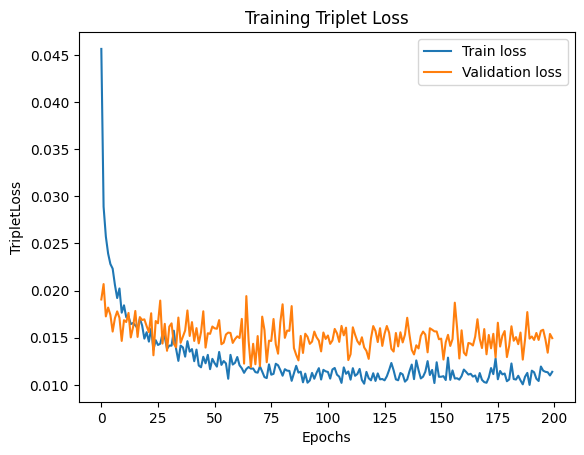

In [18]:
# printing loss function
plt.plot(loss_total, label='Train loss')
plt.plot(val_loss_total, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("TripletLoss")
plt.title("Training Triplet Loss")
plt.legend()
plt.savefig(f"loss_curves/loss_curve_{type_of_experiment}_epoch{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.png")
plt.show()

## Plotting Learning rates with epochs

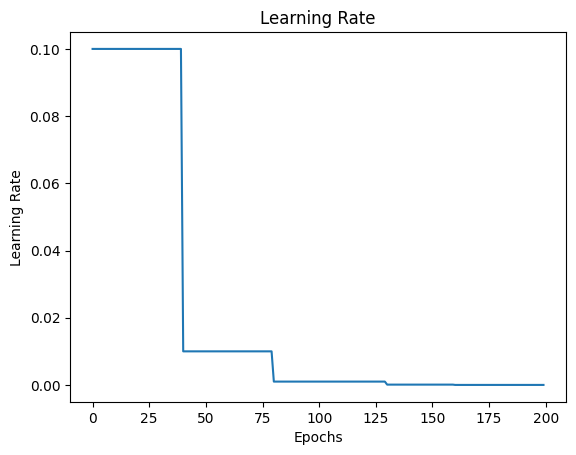

In [19]:
# printing loss function
plt.plot(learning_rates)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate")
plt.savefig(f"loss_curves/learning_curve_{type_of_experiment}_epoch{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.png")
plt.show()

In [20]:
model_path = f"models/facenet_model_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pth"
if not os.path.exists(model_path):
    torch.save(resnet, model_path)

In [21]:
model_state_path = f"models/facenet_model_statedict_{type_of_experiment}_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pth"
if not os.path.exists(model_state_path):
    torch.save(resnet.state_dict(), model_state_path)

In [22]:
# resnet = torch.load(model_path)

## Testing the trained model:

In [23]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]

test_anchor_emb = resnet(test_anchor[None, :].to(device))
test_pos_emb = resnet(test_pos[None, :].to(device))
test_neg_emb = resnet(test_neg[None, :].to(device))

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

The distance between anchor and positive: 0.4885196387767792
The distance between anchor and negative: 1.7674686908721924


## Accuracy of the model

## Creating Vault folder and vault mapping file

In [24]:
vault_path = "data/oneshot_vault_mtcnn_baseline"
label_file = "data/identity_vault_person_mtcnn_baseline.txt"

In [25]:
# creating the vault and test label file
if not os.path.exists(vault_path):
    os.makedirs(vault_path)

    # copying train images in the vault location and appending the label file
    with open(label_file, "w") as v_file:
        for i in range(len(celeba_dataset.train_df)):
            file = celeba_dataset.train_df.iloc[i]["file_name"]
            label = str(celeba_dataset.train_df.iloc[i]["person_id"])
            v_file.write(file+" "+label+"\n")

            # copying the file to the new folder
            src_file = os.path.join(img_folder, file)
            dst_file = os.path.join(vault_path, file)
            shutil.copy(src_file, dst_file)

### Creating vault embeddings or load vault embeddings if already created

In [26]:
# function to create embeddings    
def create_embeddings(celeba_dataloader, model):
    # initializing embedding vector and gt_label list
    embeddings = torch.tensor([])
    gt_labels = []
    
    # creating embeddings 
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(celeba_dataloader, 
                                                            desc="Training", position=1)):
        anchors = anchors.to(device)
        img_embs = model(anchors).detach().cpu()
        
        embeddings = torch.cat([embeddings, img_embs])
        gt_labels.extend(labels)

    return embeddings, gt_labels

In [27]:
vault_embeddings_file = f"pytorch_objects/vault_embeddings_type_{type_of_experiment}_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"
vault_gt_labels_file = f"pytorch_objects/vault_gt_labels_type_{type_of_experiment}_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"

# setting model to eval mode
resnet.eval().to(device)

celeba_dataset.mode='train'
if not os.path.exists(vault_embeddings_file) or not os.path.exists(vault_gt_labels_file):
    print('Creating embeddings...')
    embeddings, gt_labels = create_embeddings(celeba_dataloader = train_loader,
                                              model = resnet)
    
    torch.save(embeddings, vault_embeddings_file)
    torch.save(gt_labels, vault_gt_labels_file)
    print('Created embeddings.')
else:
    embeddings = torch.load(vault_embeddings_file)
    gt_labels = torch.load(vault_gt_labels_file)
    print('Embeddings loaded.')

Creating embeddings...


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Created embeddings.


In [28]:
%%time
from sklearn.neighbors import KNeighborsClassifier
embeddings = embeddings.detach().cpu()
gt_labels = torch.tensor(gt_labels)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(embeddings, gt_labels)

CPU times: user 40.7 ms, sys: 4.28 ms, total: 45 ms
Wall time: 43.6 ms


KNeighborsClassifier(n_neighbors=1)

In [29]:
# Test image:

def calculate_label(test_images, embeddings, gt_labels, embedding_model):
    # test_image_file = "s1_9.pgm"
    test_images = test_images.to(device)

    test_img_emb = embedding_model(test_images).detach().cpu()
    test_img_emb = test_img_emb[None,:].transpose(2,1).to(device)

    distance_mat = (test_img_emb - embeddings).pow(2).sum(axis=1).transpose(1,0)
    test_label_pred = gt_labels[torch.argmin(distance_mat, axis=1)]

    return test_label_pred


In [30]:
gt_labels.device

device(type='cpu')

In [31]:
gt_labels = torch.tensor(gt_labels)
torch.is_tensor(gt_labels)

/tmp/ipykernel_27461/1305761014.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_labels = torch.tensor(gt_labels)


True

In [32]:
celeba_dataset.return_triplets = False

test_predictions = torch.tensor([]).type(torch.int)
test_gt_labels = torch.tensor([]).type(torch.int)

test_embeddings = torch.tensor([])

gt_labels = gt_labels.detach().cpu()

for i, (test_imgs, test_labels) in enumerate(tqdm(test_loader, desc="Creating embeddings", position=1, leave=False)):
    test_gt_labels = torch.cat([test_gt_labels, test_labels])
    test_imgs = test_imgs.to(device)
    test_embs = resnet(test_imgs).detach().cpu()
    test_embeddings = torch.cat([test_embeddings, test_embs])

Creating embeddings:   0%|          | 0/57 [00:00<?, ?it/s]

In [33]:
test_embeddings_file = f"pytorch_objects/test_embeddings_type_{type_of_experiment}_epochs_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"
test_gt_labels_file = f"pytorch_objects/test_gt_labels_type_{type_of_experiment}_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"

if not os.path.exists(test_embeddings_file) or not os.path.exists(test_gt_labels_file):
    torch.save(test_embeddings, test_embeddings_file)
    torch.save(test_gt_labels, test_gt_labels_file)
# test_embeddings = torch.load(test_embeddings_file)
# test_gt_labels = torch.load(test_gt_labels_file)

In [34]:
score = knn.score(test_embeddings, test_gt_labels)

print(f'trained model: Accuracy = {score}.')

trained model: Accuracy = 0.4607207583995539.


In [35]:
with open(f"loss_curves/test_accuracy_type_{type_of_experiment}_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.txt", 'w') as test_acc_file:
    test_acc_file.write(f'trained model: Accuracy = {score}.')